# PROJECT: CROSS-SELLING INSURANCE POLICIES

# 1. Dataset

In [88]:
pip install --user --upgrade scikit-learn imbalanced-learn

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import RandomOverSampler

In [123]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv

df = pd.read_csv('insurance_cross_sell.csv')

print(df.head())

--2025-03-30 10:58:00--  https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.224.103, 3.5.205.241
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.224.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21432357 (20M) [text/csv]
Saving to: ‘insurance_cross_sell.csv’

insurance_cross_sel 100%[===================>]  20.44M  17.3MB/s    in 1.2s    

2025-03-30 10:58:02 (17.3 MB/s) - ‘insurance_cross_sell.csv’ saved [21432357/21432357]

   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1

In [124]:
df.shape

(381109, 12)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


# 2. Analysis

In [126]:
df[["Age", "Annual_Premium", "Vintage"]].describe()

,Age,Annual_Premium,Vintage
count,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397
std,15.511611,17213.155057,83.671304
min,20.000000,2630.000000,10.000000
25%,25.000000,24405.000000,82.000000
50%,36.000000,31669.000000,154.000000
75%,49.000000,39400.000000,227.000000
max,85.000000,540165.000000,299.000000


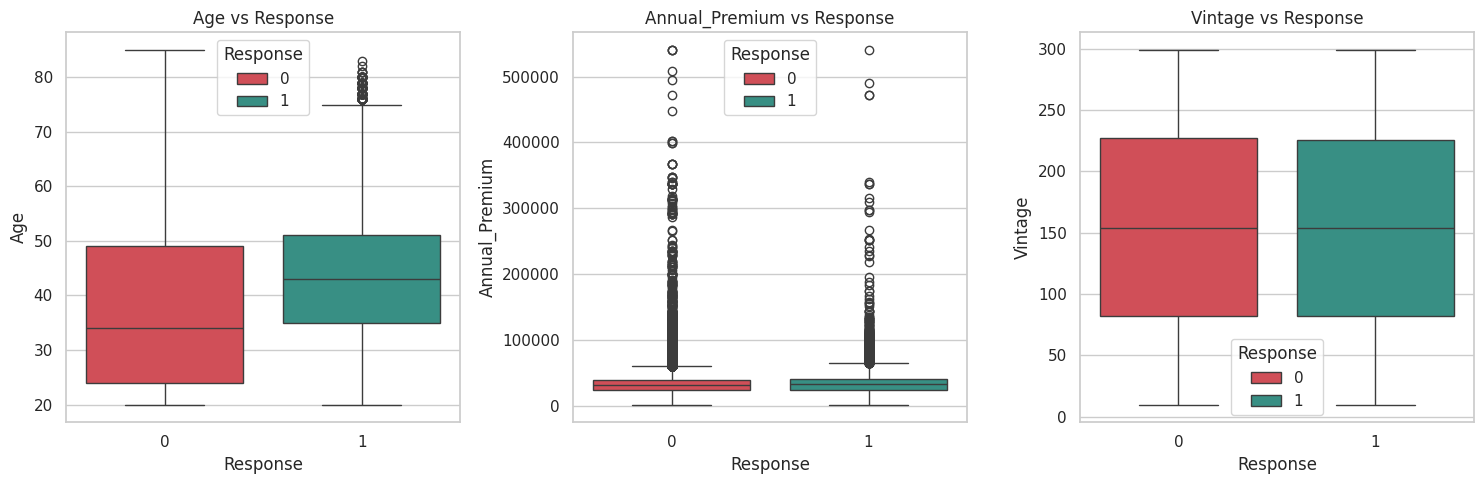

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

variables = ["Age", "Annual_Premium", "Vintage"]

for i, var in enumerate(variables):
    sns.boxplot(x="Response",
                y=var,
                data=df,
                hue="Response",
                palette=["#E63946", "#2A9D8F"],
                ax=axes[i])

    axes[i].set_title(f"{var} vs Response")

plt.tight_layout()
plt.show()

From the boxplots obtained, it is clear that the Response target is influenced by the Age feature. The Annual_Premium and Vintage features, on the other hand, do not seem to influence the target, as the boxplots are almost identical both in the case of a positive response (Response = 1) and a negative response (Response = 0).

In [128]:
response_counts = df["Response"].value_counts()
response_perc = (df["Response"].value_counts(normalize=True)*100).round(2)
response_df = pd.DataFrame({"Counts": response_counts,
                            "Percentages": response_perc})
response_df.index.name = "Response"
print(response_df)

print("----------------------------------------")

license_counts = df["Driving_License"].value_counts()
license_perc = (df["Driving_License"].value_counts(normalize=True)*100).round(2)
license_df = pd.DataFrame({"Counts": license_counts,
                           "Percentages": license_perc})
license_df.index.name = "Driving_License"
print(license_df)

print("----------------------------------------")

insured_counts = df["Previously_Insured"].value_counts()
insured_perc = (df["Previously_Insured"].value_counts(normalize=True)*100).round(2)
insured_df = pd.DataFrame({"Counts": insured_counts,
                           "Percentages": insured_perc})
insured_df.index.name = "Previously_Insured"
print(insured_df)

print("----------------------------------------")

gender_counts = df["Gender"].value_counts()
gender_perc = (df["Gender"].value_counts(normalize=True)*100).round(2)
gender_df = pd.DataFrame({"Counts": gender_counts,
                          "Percentages": gender_perc})
gender_df.index.name = "Gender"
print(gender_df)

print("----------------------------------------")

damage_counts = df["Vehicle_Damage"].value_counts()
damage_perc = (df["Vehicle_Damage"].value_counts(normalize=True)*100).round(2)
damage_df = pd.DataFrame({"Counts": damage_counts,
                          "Percentages": damage_perc})
damage_df.index.name = "Vehicle_Damage"
print(damage_df)

print("----------------------------------------")

vehi_age_counts = df["Vehicle_Age"].value_counts()
vehi_age_perc = (df["Vehicle_Age"].value_counts(normalize=True)*100).round(2)
vehi_age_df = pd.DataFrame({"Counts": vehi_age_counts,
                            "Percentages": vehi_age_perc})
vehi_age_df.index.name = "Vehicle_Age"
print(vehi_age_df)

print("----------------------------------------")

          Counts  Percentages
Response                     
0         334399        87.74
1          46710        12.26
----------------------------------------
                 Counts  Percentages
Driving_License                     
1                380297        99.79
0                   812         0.21
----------------------------------------
                    Counts  Percentages
Previously_Insured                     
0                   206481        54.18
1                   174628        45.82
----------------------------------------
        Counts  Percentages
Gender                     
Male    206089        54.08
Female  175020        45.92
----------------------------------------
                Counts  Percentages
Vehicle_Damage                     
Yes             192413        50.49
No              188696        49.51
----------------------------------------
             Counts  Percentages
Vehicle_Age                     
1-2 Year     200316        52.56
< 1 Year    

The Response target is a variable with two unbalanced classes, in fact, 87.74% of the samples fall into the negative class (Response = 0) and 12.26% into the positive class (Response = 1). Similarly, the Driving_License feature is unbalanced, and in this case even more extreme: 99.79% of the buyers in the dataset have a driving license. The Previously_Insured, Gender and Vehicle_Damage features, on the other hand, have balanced classes: one class with approximately 54% of the samples and the other with 46% in all three cases. Finally, the trimodal Vehicle_Age feature has two equally distributed classes ("1-2 Year" 52.56% and "< 1 Year" 43.24%) and a class with much fewer samples ("> 2 Years" 4.20%).

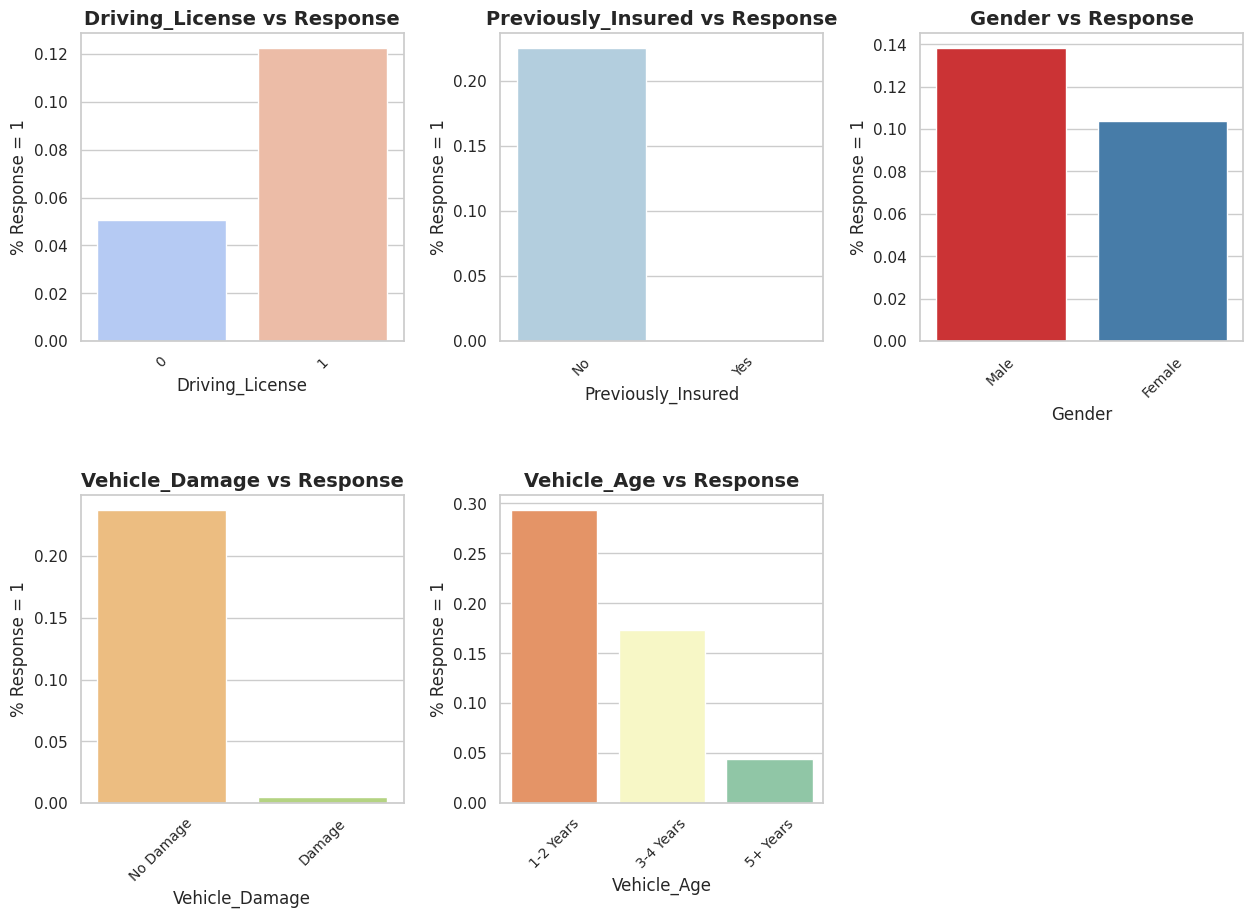

In [129]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

vars = ["Driving_License", "Previously_Insured", "Gender", "Vehicle_Damage", "Vehicle_Age"]

palettes = [
    sns.color_palette("coolwarm", 2),
    sns.color_palette("Blues", 2),
    sns.color_palette("Set1", 2),
    sns.color_palette("RdYlGn", 2),
    sns.color_palette("Spectral", 3)
]

for i, var in enumerate(vars):
    ax = axes[i // 3, i % 3]

    sns.barplot(x=var,
                y="Response",
                data=df,
                hue=var,
                dodge=False,
                ax=ax,
                palette=palettes[i],
                errorbar=None)

    ax.set_title(f"{var} vs Response", fontsize=14, fontweight="bold")
    ax.set_ylabel("% Response = 1", fontsize=12)
    ax.set_xlabel(f"{var}", fontsize=12)

    ax.tick_params(axis='x', rotation=45, labelsize=10)

    if var == "Driving_License":
        ax.set_xticklabels(['0', '1'], fontsize=10)
    elif var == "Previously_Insured":
        ax.set_xticklabels(['No', 'Yes'], fontsize=10)
    elif var == "Gender":
        ax.set_xticklabels(['Male', 'Female'], fontsize=10)
    elif var == "Vehicle_Damage":
        ax.set_xticklabels(['No Damage', 'Damage'], fontsize=10)
    elif var == "Vehicle_Age":
        ax.set_xticklabels(['1-2 Years', '3-4 Years', '5+ Years'], fontsize=10)

    if ax.get_legend():
        ax.get_legend().remove()

axes[1, 2].axis('off')

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()

The previous barplots show the classes of each qualitative variable on the x-axis and the percentage of positive responses to the sales proposal (Response = 1) per class on the y-axis.The percentage of buyers with a driving license who respond positively to the proposal (about 12%) is higher than those without a driving license (about 5%). Only buyers who do not already have an insured vehicle respond positively to the proposal. Male buyers seem to give a positive response to the sales proposal more frequently than female buyers, although the difference is not too marked. About 24% of buyers who have already damaged the vehicle in the past respond positively to the proposal, while almost none of those who have not damaged the vehicle respond positively.

In [130]:
print("Region_Code")
region_code_min = df["Region_Code"].min()
region_code_max = df["Region_Code"].max()
region_code_num_classes = df["Region_Code"].nunique()
region_code_df = pd.DataFrame({"Min": [region_code_min],
                               "Max": [region_code_max],
                               "num_classes": [region_code_num_classes]})
print(region_code_df.to_string(index=False))

print("\nMost frequent regional codes")
print(df["Region_Code"].value_counts().head(3))

print("\nLess frequent region codes")
print(df["Region_Code"].value_counts().tail(3))

print("----------------------------------------")

print("Policy_Sales_Channel")
sales_channel_min = df["Policy_Sales_Channel"].min()
sales_channel_max = df["Policy_Sales_Channel"].max()
sales_channel_num_classes = df["Policy_Sales_Channel"].nunique()
sales_channel_df = pd.DataFrame({"Min": [sales_channel_min],
                               "Max": [sales_channel_max],
                               "num_classes": [sales_channel_num_classes]})
print(sales_channel_df.to_string(index=False))

print("\nMost frequent policy sales channel")
print(df["Policy_Sales_Channel"].value_counts().head(3))

print("\nLess frequent policy sales channel")
print(df["Policy_Sales_Channel"].value_counts().tail(3))

Region_Code
 Min  Max  num_classes
 0.0 52.0           53

Most frequent regional codes
Region_Code
28.0    106415
8.0      33877
46.0     19749
Name: count, dtype: int64

Less frequent region codes
Region_Code
42.0    591
52.0    267
51.0    183
Name: count, dtype: int64
----------------------------------------
Policy_Sales_Channel
 Min   Max  num_classes
 1.0 163.0          155

Most frequent policy sales channel
Policy_Sales_Channel
152.0    134784
26.0      79700
124.0     73995
Name: count, dtype: int64

Less frequent policy sales channel
Policy_Sales_Channel
144.0    1
143.0    1
41.0     1
Name: count, dtype: int64


As for the Region_Code and Policy_Sales_Channel features, instead, being nominal qualitative variables expressed through numeric codes with numerous modalities, statistics on the range of variation of the codes were first obtained, and secondly the most frequent and least frequent classes were obtained. Therefore, from the results obtained it can be seen that the unique regional codes present in the dataset are 53, from code 0 to code 52, while the anonymized codes of the channels used for the proposal are 155 and cover a range that goes from code number 1 to number 163. As for the unique codes of the buyers' regions, there do not seem to be any particular patterns, although there are some regions where the percentage of positive responses is higher than the majority. Even the anonymized codes of the channels used for the proposal do not seem to have significant patterns.

# 3. Feature Encoding

In [97]:
size_mapping = {"Male": 1, "Female": 0}
df["Gender"] = df["Gender"].map(size_mapping)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [98]:
size_mapping = {"Yes": 1, "No": 0}
df["Vehicle_Damage"] = df["Vehicle_Damage"].map(size_mapping)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,> 2 Years,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1-2 Year,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,> 2 Years,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,< 1 Year,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,< 1 Year,0,27496.0,152.0,39,0


In [99]:
size_mapping = {"< 1 Year": 1, "1-2 Year": 2, "> 2 Years": 3}
df["Vehicle_Age"] = df["Vehicle_Age"].map(size_mapping)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,2,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0


In [100]:
df = pd.get_dummies(df, columns=["Region_Code"])
df.head()

,id,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
0,1,1,44,1,0,3,1,40454.0,26.0,217,...,False,False,False,False,False,False,False,False,False,False
1,2,1,76,1,0,2,0,33536.0,26.0,183,...,False,False,False,False,False,False,False,False,False,False
2,3,1,47,1,0,3,1,38294.0,26.0,27,...,False,False,False,False,False,False,False,False,False,False
3,4,1,21,1,1,1,0,28619.0,152.0,203,...,False,False,False,False,False,False,False,False,False,False
4,5,0,29,1,1,1,0,27496.0,152.0,39,...,False,False,False,False,False,False,False,False,False,False


In [101]:
df = pd.get_dummies(df, columns=["Policy_Sales_Channel"])
df.head()

,id,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,...,Policy_Sales_Channel_152.0,Policy_Sales_Channel_153.0,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0
0,1,1,44,1,0,3,1,40454.0,217,1,...,False,False,False,False,False,False,False,False,False,False
1,2,1,76,1,0,2,0,33536.0,183,0,...,False,False,False,False,False,False,False,False,False,False
2,3,1,47,1,0,3,1,38294.0,27,1,...,False,False,False,False,False,False,False,False,False,False
3,4,1,21,1,1,1,0,28619.0,203,0,...,True,False,False,False,False,False,False,False,False,False
4,5,0,29,1,1,1,0,27496.0,39,0,...,True,False,False,False,False,False,False,False,False,False


It can be observed that, once the one-hot encoding is used for the Region_Code and Policy_Sales_Channel features, the size of the dataset increases considerably, going from 11 to 217 columns. This increase in size makes the model more complex and the consequent training requires more computational resources.

# 4. Models

To identify a model that predicts the probability of a customer to respond positively to the cross-sell offer, I proceed to preliminarily create 4 models. Each Model includes different features and parameters. By comparing them and using appropriate techniques, I will identify the best model.

- Model 0: model with all features and no technique used to handle class imbalance.
- Model 1: model with all features and use of the class_weight="balanced" parameter.
- Model 2: model with all features and use of the oversampling technique.
- Model 3: model with selected features and use of the class_weight="balanced" parameter.
- Model 4: model with selected features and use of the oversampling technique.

MODEL 0

In [102]:
X = df.drop("Response",  axis=1).values
y = df["Response"].values

np.set_printoptions(suppress=True, precision=2)

print("Features array")
print(X[:5], X.shape)

print("\nTarget array")
print(y[:5], y.shape)

Features array
[[1 1 44 ... False False False]
 [2 1 76 ... False False False]
 [3 1 47 ... False False False]
 [4 1 21 ... False False False]
 [5 0 29 ... False False False]] (381109, 217)

Target array
[1 0 1 0 0] (381109,)


In [103]:
def classification_report(y_true, y_pred):

    precision_0 = round(precision_score(y_true, y_pred, pos_label=0), 4)
    recall_0 = round(recall_score(y_true, y_pred, pos_label=0), 4)
    f1_0 = round(f1_score(y_true, y_pred, pos_label=0), 4)
    accuracy_0 = round(accuracy_score(y_true, y_pred), 4)

    precision_1 = round(precision_score(y_true, y_pred, pos_label=1), 4)
    recall_1 = round(recall_score(y_true, y_pred, pos_label=1), 4)
    f1_1 = round(f1_score(y_true, y_pred, pos_label=1), 4)
    accuracy_1 = round(accuracy_score(y_true, y_pred), 4)

    results = {"Class": [0, 1],
               "Precision": [precision_0, precision_1],
               "Recall": [recall_0, recall_1],
               "F1-score": [f1_0, f1_1],
               "Accuracy": [accuracy_0, accuracy_1]}

    df_results = pd.DataFrame(results)
    return df_results

In [104]:
train_reports = []
test_reports = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    train_reports.append(classification_report(y_train, y_pred_train))
    test_reports.append(classification_report(y_test, y_pred_test))

train_results_df_mod0 = pd.concat(train_reports,
                                  keys=range(1, kf.n_splits + 1),
                                  names=["Fold"])
test_results_df_mod0 = pd.concat(test_reports,
                                 keys=range(1, kf.n_splits + 1),
                                 names=["Fold"])

print("Train results mod0: all features + unbalanced classes")
print(train_results_df_mod0)

print("\nTest results mod0: all features + unbalanced classes")
print(test_results_df_mod0)

Train results mod0: all features + unbalanced classes
        Class  Precision  Recall  F1-score  Accuracy
Fold                                                
1    0      0     0.8782  0.9996    0.9350    0.8779
     1      1     0.4235  0.0019    0.0039    0.8779
2    0      0     0.8776  0.9995    0.9346    0.8773
     1      1     0.4039  0.0022    0.0044    0.8773
3    0      0     0.8777  0.9994    0.9346    0.8773
     1      1     0.4014  0.0031    0.0062    0.8773
4    0      0     0.8770  0.9995    0.9342    0.8766
     1      1     0.4122  0.0027    0.0053    0.8766
5    0      0     0.8778  0.9993    0.9346    0.8774
     1      1     0.4413  0.0037    0.0074    0.8774

Test results mod0: all features + unbalanced classes
        Class  Precision  Recall  F1-score  Accuracy
Fold                                                
1    0      0     0.8751  0.9997    0.9333    0.8749
     1      1     0.2903  0.0009    0.0019    0.8749
2    0      0     0.8777  0.9994    0.9346  

In [105]:
mean_train_results_mod0 = round(train_results_df_mod0.groupby("Class").mean(), 4)
mean_test_results_mod0 = round(test_results_df_mod0.groupby("Class").mean(), 4)

print("Mean train results mod0: all features + unbalanced classes")
print(mean_train_results_mod0)

print("\nMean test results mod0: all features + unbalanced classes")
print(mean_test_results_mod0)

Mean train results mod0: all features + unbalanced classes
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.8777  0.9995    0.9346    0.8773
1         0.4165  0.0027    0.0054    0.8773

Mean test results mod0: all features + unbalanced classes
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.8776  0.9994    0.9345    0.8772
1         0.3304  0.0021    0.0042    0.8772


The model appears to have very good accuracy, around 88%, on both the training and test sets. However, the recall is almost 100% for class 0, and almost 0% for class 1, for both the training and test sets, indicating that the model is unable to correctly classify examples belonging to the positive class.

MODEL 1

In [106]:
train_reports = []
test_reports = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_num, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"Fold {fold_num}")
    print(f"\nX_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"Distr_y_classes_train: {np.unique(y_train, return_counts=True)}")
    print(f"\nX_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"Distr_y_classes_test: {np.unique(y_test, return_counts=True)}")
    print("-----------------------------------------------------------------")

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    lr = LogisticRegression(class_weight="balanced", random_state=42)
    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    train_reports.append(classification_report(y_train, y_pred_train))
    test_reports.append(classification_report(y_test, y_pred_test))

train_results_df_mod1 = pd.concat(train_reports,
                                  keys=range(1, kf.n_splits + 1),
                                  names=["Fold"])
test_results_df_mod1 = pd.concat(test_reports,
                                 keys=range(1, kf.n_splits + 1),
                                 names=["Fold"])

print("\nTrain results mod1: all features + class_weight='balanced'")
print(train_results_df_mod1)

print("\nTest results mod1: all features + class_weight='balanced'")
print(test_results_df_mod1)

Fold 1

X_train shape: (304887, 217)
y_train shape: (304887,)
Distr_y_classes_train: (array([0, 1]), array([267700,  37187]))

X_test shape: (76222, 217)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66699,  9523]))
-----------------------------------------------------------------
Fold 2

X_train shape: (304887, 217)
y_train shape: (304887,)
Distr_y_classes_train: (array([0, 1]), array([267520,  37367]))

X_test shape: (76222, 217)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66879,  9343]))
-----------------------------------------------------------------
Fold 3

X_train shape: (304887, 217)
y_train shape: (304887,)
Distr_y_classes_train: (array([0, 1]), array([267526,  37361]))

X_test shape: (76222, 217)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66873,  9349]))
-----------------------------------------------------------------
Fold 4

X_train shape: (304887, 217)
y_train shape: (304887,)
Distr_y_classes_train: (ar

In [107]:
mean_train_results_mod1 = round(train_results_df_mod1.groupby("Class").mean(), 4)
mean_test_results_mod1 = round(test_results_df_mod1.groupby("Class").mean(), 4)

print("Mean train results mod1: all features + class_weight='balanced'")
print(mean_train_results_mod1)

print("\nMean test results mod1: all features + class_weight='balanced'")
print(mean_test_results_mod1)

Mean train results mod1: all features + class_weight='balanced'
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9869  0.6604    0.7913    0.6943
1         0.2782  0.9371    0.4291    0.6943

Mean test results mod1: all features + class_weight='balanced'
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9864  0.6603    0.7911    0.6939
1         0.2776  0.9347    0.4281    0.6939


Compared to Model 0, significant improvements can be observed. In fact, although the accuracy has decreased, going from about 88% to 70%, the recall of the positive class is no longer almost equal to 0% but reaches 93% indicating a low number of false negatives. However, the precision of the positive class is low (28%): a low percentage of positive classifications that are actually positive.

MODEL 2

In [108]:
train_reports = []
test_reports = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_num, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    oversample = RandomOverSampler(sampling_strategy="minority",
                                   random_state=42)

    X_train, y_train = oversample.fit_resample(X_train, y_train)

    print(f"Fold {fold_num}")
    print(f"\nX_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"Distr_y_classes_train: {np.unique(y_train, return_counts=True)}")
    print(f"\nX_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"Distr_y_classes_test: {np.unique(y_test, return_counts=True)}")
    print("-----------------------------------------------------------------")

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    train_reports.append(classification_report(y_train, y_pred_train))
    test_reports.append(classification_report(y_test, y_pred_test))

train_results_df_mod2 = pd.concat(train_reports,
                                  keys=range(1, kf.n_splits + 1),
                                  names=["Fold"])
test_results_df_mod2 = pd.concat(test_reports,
                                 keys=range(1, kf.n_splits + 1),
                                 names=["Fold"])

print("\nTrain results mod2: all features + oversampling")
print(train_results_df_mod2)

print("\nTest results mod2: all features + oversampling")
print(test_results_df_mod2)

Fold 1

X_train shape: (535400, 217)
y_train shape: (535400,)
Distr_y_classes_train: (array([0, 1]), array([267700, 267700]))

X_test shape: (76222, 217)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66699,  9523]))
-----------------------------------------------------------------
Fold 2

X_train shape: (535040, 217)
y_train shape: (535040,)
Distr_y_classes_train: (array([0, 1]), array([267520, 267520]))

X_test shape: (76222, 217)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66879,  9343]))
-----------------------------------------------------------------
Fold 3

X_train shape: (535052, 217)
y_train shape: (535052,)
Distr_y_classes_train: (array([0, 1]), array([267526, 267526]))

X_test shape: (76222, 217)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66873,  9349]))
-----------------------------------------------------------------
Fold 4

X_train shape: (534630, 217)
y_train shape: (534630,)
Distr_y_classes_train: (ar

In [109]:
mean_train_results_mod2 = round(train_results_df_mod2.groupby("Class").mean(), 4)
mean_test_results_mod2 = round(test_results_df_mod2.groupby("Class").mean(), 4)

print("Mean train results mod2: all features + oversampling")
print(mean_train_results_mod2)

print("\nMean test results mod2: all features + oversampling")
print(mean_test_results_mod2)

Mean train results mod2: all features + oversampling
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9131  0.6599    0.7661    0.7985
1         0.7337  0.9372    0.8231    0.7985

Mean test results mod2: all features + oversampling
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9865  0.6596    0.7905    0.6933
1         0.2773  0.9352    0.4278    0.6933


The performance obtained on the test set is almost identical to that obtained with the previous model, however, in this case, the precision of class 1 on the train set is 73% and that on the test set is 28% and it is assumed that there may be overfitting.

MODEL 3

In [110]:
X = df[["Gender",
        "Age",
        "Driving_License",
        "Previously_Insured",
        "Vehicle_Age",
        "Vehicle_Damage"]].values

y = df["Response"].values

np.set_printoptions(suppress=True, precision=2)

print("Features array")
print(X[:5], X.shape)

print("\nTarget array")
print(y[:5], y.shape)

Features array
[[ 1 44  1  0  3  1]
 [ 1 76  1  0  2  0]
 [ 1 47  1  0  3  1]
 [ 1 21  1  1  1  0]
 [ 0 29  1  1  1  0]] (381109, 6)

Target array
[1 0 1 0 0] (381109,)


In [111]:
train_reports = []
test_reports = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_num, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"Fold {fold_num}")
    print(f"\nX_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"Distr_y_classes_train: {np.unique(y_train, return_counts=True)}")
    print(f"\nX_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"Distr_y_classes_test: {np.unique(y_test, return_counts=True)}")
    print("-----------------------------------------------------------------")

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    lr = LogisticRegression(class_weight="balanced", random_state=42)
    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    train_reports.append(classification_report(y_train, y_pred_train))
    test_reports.append(classification_report(y_test, y_pred_test))

train_results_df_mod3 = pd.concat(train_reports,
                                  keys=range(1, kf.n_splits + 1),
                                  names=["Fold"])
test_results_df_mod3 = pd.concat(test_reports,
                                 keys=range(1, kf.n_splits + 1),
                                 names=["Fold"])

print("\nTrain results mod3: features selection + class_weight='balanced'")
print(train_results_df_mod3)

print("\nTest results mod3: features selection + class_weight='balanced'")
print(test_results_df_mod3)

Fold 1

X_train shape: (304887, 6)
y_train shape: (304887,)
Distr_y_classes_train: (array([0, 1]), array([267700,  37187]))

X_test shape: (76222, 6)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66699,  9523]))
-----------------------------------------------------------------
Fold 2

X_train shape: (304887, 6)
y_train shape: (304887,)
Distr_y_classes_train: (array([0, 1]), array([267520,  37367]))

X_test shape: (76222, 6)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66879,  9343]))
-----------------------------------------------------------------
Fold 3

X_train shape: (304887, 6)
y_train shape: (304887,)
Distr_y_classes_train: (array([0, 1]), array([267526,  37361]))

X_test shape: (76222, 6)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66873,  9349]))
-----------------------------------------------------------------
Fold 4

X_train shape: (304887, 6)
y_train shape: (304887,)
Distr_y_classes_train: (array([0, 1]), a

In [112]:
mean_train_results_mod3 = round(train_results_df_mod3.groupby("Class").mean(), 4)
mean_test_results_mod3 = round(test_results_df_mod3.groupby("Class").mean(), 4)

print("Mean train results mod3: features selection + class_weight='balanced'")
print(mean_train_results_mod3)

print("\nMean test results mod3: features selection + class_weight='balanced'")
print(mean_test_results_mod3)

Mean train results mod3: features selection + class_weight='balanced'
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9943  0.5922    0.7423    0.6392
1         0.2505  0.9757    0.3986    0.6392

Mean test results mod3: features selection + class_weight='balanced'
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9943  0.5922    0.7423    0.6392
1         0.2505  0.9757    0.3986    0.6392


It is possible to observe that the performance on the test set is very similar to that on the train set indicating no overfitting. Furthermore, compared to the exact same model with all the features, mod3 has an accuracy that has decreased from 70% to 64% with the precision of class 1 that has decreased from 28% to 25%. However, the recall of class 1, a fundamental parameter, has increased from 93% to 98%.

MODEL 4

In [113]:
train_reports = []
test_reports = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_num, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    oversample = RandomOverSampler(sampling_strategy="minority",
                                   random_state=42)

    X_train, y_train = oversample.fit_resample(X_train, y_train)

    print(f"Fold {fold_num}")
    print(f"\nX_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"Distr_y_classes_train: {np.unique(y_train, return_counts=True)}")
    print(f"\nX_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"Distr_y_classes_test: {np.unique(y_test, return_counts=True)}")
    print("-----------------------------------------------------------------")

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    train_reports.append(classification_report(y_train, y_pred_train))
    test_reports.append(classification_report(y_test, y_pred_test))

train_results_df_mod4 = pd.concat(train_reports,
                                  keys=range(1, kf.n_splits + 1),
                                  names=["Fold"])
test_results_df_mod4 = pd.concat(test_reports,
                                 keys=range(1, kf.n_splits + 1),
                                 names=["Fold"])

print("\nTrain results mod4: features selection + oversampling")
print(train_results_df_mod4)

print("\nTest results mod4: features selection + oversampling")
print(test_results_df_mod4)

Fold 1

X_train shape: (535400, 6)
y_train shape: (535400,)
Distr_y_classes_train: (array([0, 1]), array([267700, 267700]))

X_test shape: (76222, 6)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66699,  9523]))
-----------------------------------------------------------------
Fold 2

X_train shape: (535040, 6)
y_train shape: (535040,)
Distr_y_classes_train: (array([0, 1]), array([267520, 267520]))

X_test shape: (76222, 6)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66879,  9343]))
-----------------------------------------------------------------
Fold 3

X_train shape: (535052, 6)
y_train shape: (535052,)
Distr_y_classes_train: (array([0, 1]), array([267526, 267526]))

X_test shape: (76222, 6)
y_test shape: (76222,)
Distr_y_classes_test: (array([0, 1]), array([66873,  9349]))
-----------------------------------------------------------------
Fold 4

X_train shape: (534630, 6)
y_train shape: (534630,)
Distr_y_classes_train: (array([0, 1]), a

In [114]:
mean_train_results_mod4 = round(train_results_df_mod4.groupby("Class").mean(), 4)
mean_test_results_mod4 = round(test_results_df_mod4.groupby("Class").mean(), 4)

print("Mean train results mod4: features selection + oversampling")
print(mean_train_results_mod4)

print("\nMean test results mod4: features selection + oversampling")
print(mean_test_results_mod4)

Mean train results mod4: features selection + oversampling
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9606  0.5921    0.7327    0.7839
1         0.7052  0.9757    0.8187    0.7839

Mean test results mod4: features selection + oversampling
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9943  0.5922    0.7423    0.6392
1         0.2505  0.9757    0.3986    0.6392


The mod4 has performances on the test set equal to the previous mod3. However, as it happened for its version with all the features (mod2) there is overfitting on the precision of the positive class: 0.7052 for the train set and 0.2505 for the test set.

In [115]:
#Model1
mean_train_results_mod1 = round(train_results_df_mod1.groupby("Class").mean(), 4)
mean_test_results_mod1 = round(test_results_df_mod1.groupby("Class").mean(), 4)

print("Mod1: all features + class_weight='balanced'")
print(mean_train_results_mod1)

print("\nMod1: all features + class_weight='balanced'")
print(mean_test_results_mod1)

print("--------------------------------------------------")

#Model2
mean_train_results_mod2 = round(train_results_df_mod2.groupby("Class").mean(), 4)
mean_test_results_mod2 = round(test_results_df_mod2.groupby("Class").mean(), 4)

print("Mod2: all features + oversampling")
print(mean_train_results_mod2)

print("\nMod2: all features + oversampling")
print(mean_test_results_mod2)

print("--------------------------------------------------")

#Model3
mean_train_results_mod3 = round(train_results_df_mod3.groupby("Class").mean(), 4)
mean_test_results_mod3 = round(test_results_df_mod3.groupby("Class").mean(), 4)

print("Mod3: features selection + class_weight='balanced'")
print(mean_train_results_mod3)

print("\nMod3: features selection + class_weight='balanced'")
print(mean_test_results_mod3)

print("--------------------------------------------------")

#Model4
mean_train_results_mod4 = round(train_results_df_mod4.groupby("Class").mean(), 4)
mean_test_results_mod4 = round(test_results_df_mod4.groupby("Class").mean(), 4)

print("Mod4: features selection + oversampling")
print(mean_train_results_mod4)

print("\nMod4: features selection + oversampling")
print(mean_test_results_mod4)

Mod1: all features + class_weight='balanced'
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9869  0.6604    0.7913    0.6943
1         0.2782  0.9371    0.4291    0.6943

Mod1: all features + class_weight='balanced'
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9864  0.6603    0.7911    0.6939
1         0.2776  0.9347    0.4281    0.6939
--------------------------------------------------
Mod2: all features + oversampling
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9131  0.6599    0.7661    0.7985
1         0.7337  0.9372    0.8231    0.7985

Mod2: all features + oversampling
       Precision  Recall  F1-score  Accuracy
Class                                       
0         0.9865  0.6596    0.7905    0.6933
1         0.2773  0.9352    0.4278    0.6933
--------------------------------------------------
Mod3: features sel

To select the most suitable model, it is important to keep in mind the primary goal of insurance: to develop a predictive model that can determine whether previous year's customers might be interested in purchasing a policy for their vehicle. Therefore, the main goal in terms of metrics is to maximize the recall for the positive class (Response=1, i.e. proposal accepted), thus minimizing false negatives. This means that, while sacrificing precision and accuracy, you want to avoid losing potential buyers of the policy.

In this context, we can immediately discard the mod1 and mod2 models, which use all features, for the following reasons (based on the results obtained on the test set):

- although they have higher precision and accuracy than the feature-selected models (70% precision and 64% accuracy), they have lower recall (93% compared to 98% for the feature-selected models).

- They use a high number of features (381109 for mod1 and 216 for mod2) due to the one-hot encoding of the Region_Code and Policy_Sales_Channel variables. This additional complexity, which increases the training time, does not justify the lower results, especially for the main metric, recall.

Therefore, the choice remains between the two models with feature selection: mod3 and mod4. Both show identical performance on the test set, so the decision can be driven by the different complexity of the models and their training processes. Mod3 uses the class_weight="balanced" parameter to balance the Response classes, applying a 5-fold cross-validation on about 304887 samples. On the other hand, mod4 uses the oversampling technique, with folds comprising about 535000 samples.

In light of these considerations, the preferred model, given equal performance, is mod3, as it offers greater simplicity. The performance of mod3 on the test set is excellent, with a 98% recall for class 1, almost completely reducing false negatives. This allows the insurance company to save time and resources, by contacting only potential buyers of the policy, without losing any potential customers. Although the precision for class 1 is relatively low (25%), this value can be accepted given the primary objective of the model.

Once mod3 is chosen as the "best" model, it is possible to proceed with the construction of the confusion matrix and the ROC curve, including the area under the AUC curve for a further evaluation of its performance.

# 5. Final Results and Model Choice

In [116]:
total_train_conf_matrix = np.zeros((2, 2))
total_test_conf_matrix = np.zeros((2, 2))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    lr = LogisticRegression(class_weight="balanced", random_state=42)
    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    train_conf_matrix = confusion_matrix(y_train, y_pred_train)
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)

    total_train_conf_matrix += train_conf_matrix
    total_test_conf_matrix += test_conf_matrix

mean_train_conf_matrix = total_train_conf_matrix / kf.n_splits
mean_test_conf_matrix = total_test_conf_matrix / kf.n_splits

print("Mean train confusion matrix:")
print(mean_train_conf_matrix)

print("\nMean test confusion matrix:")
print(mean_test_conf_matrix)

Mean train confusion matrix:
[[158411.6 109107.6]
 [   908.4  36459.6]]

Mean test confusion matrix:
[[39604.  27275.8]
 [  227.2  9114.8]]


In [50]:
def plot_confusion_matrix(cm,
                          labels=["Negative", "Positive"],
                          show_precision_recall=True):

    df_cm = pd.DataFrame(cm,
                         index = labels,
                         columns = ["Predicted "+labels[0],"Predicted "+labels[1]])

    sns.heatmap(df_cm, annot=True, fmt='g')

    if show_precision_recall:
        plt.text(0, -0.1, f"Precision: {(cm[1][1]/(cm[1][1]+cm[0][1])):.4f}")
        plt.text(1, -0.1, f"Recall: {(cm[1][1]/(cm[1][1]+cm[1][0])):.4f}")

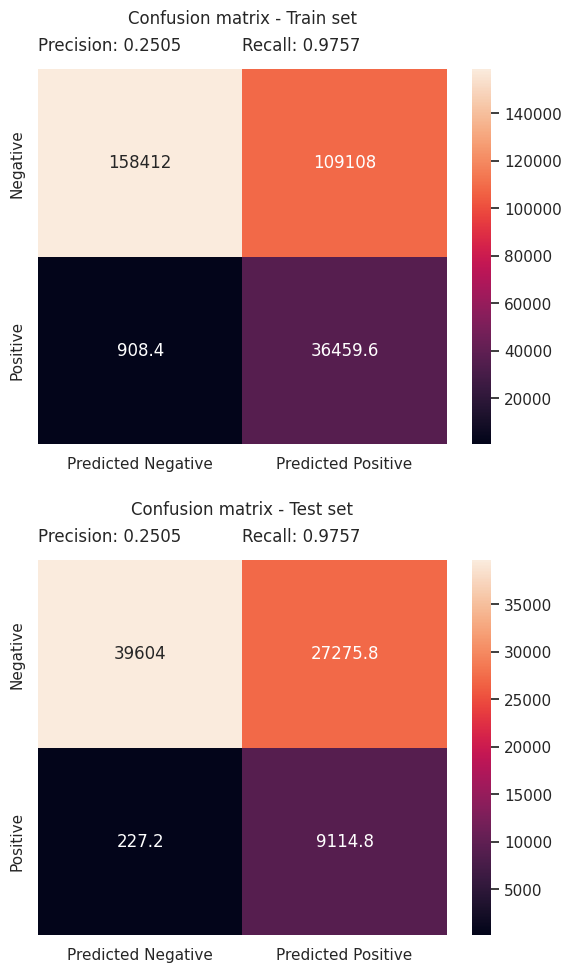

In [117]:
fig, axes = plt.subplots(2, 1, figsize=(6, 10))

plt.subplot(2, 1, 1)
plot_confusion_matrix(mean_train_conf_matrix)
plt.title("Confusion matrix - Train set", y=1.1)

plt.subplot(2, 1, 2)
plot_confusion_matrix(mean_test_conf_matrix)
plt.title("Confusion matrix - Test set", y=1.1)

plt.subplots_adjust(hspace=-0.4)

plt.tight_layout()
plt.show()

Thanks to the use of the heatmap it is possible to immediately notice how the false negatives are very small in number not only by observing the count of negative predictions that are actually positive (227 in the test set) but also by observing the dark color of the box that corresponds to the lowest values in the legend on the right.

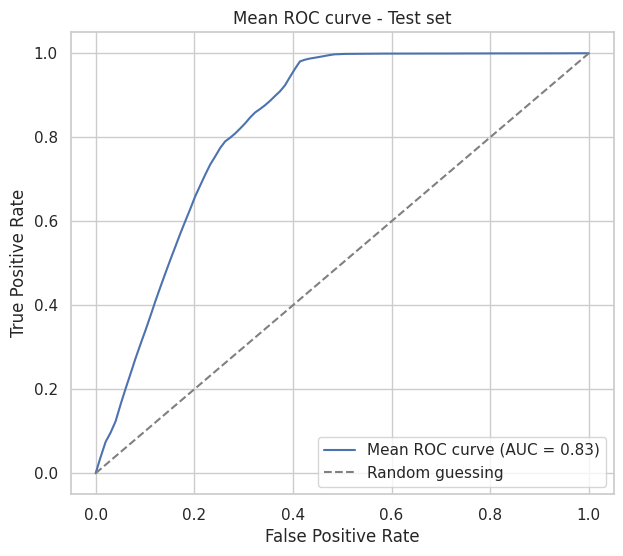

In [118]:
all_tpr = []
all_fpr = []
all_auc = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    lr = LogisticRegression(class_weight="balanced", random_state=42)
    lr.fit(X_train, y_train)

    y_proba_test = lr.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba_test)
    all_tpr.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))
    all_fpr.append(np.linspace(0, 1, 100))

    roc_auc = auc(fpr, tpr)
    all_auc.append(roc_auc)

mean_tpr = np.mean(all_tpr, axis=0)
mean_auc = np.mean(all_auc)

plt.figure(figsize=(7, 6))
plt.plot(all_fpr[0], mean_tpr, color="b", label=f"Mean ROC curve (AUC = {mean_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random guessing")
plt.title("Mean ROC curve - Test set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

The average ROC curve of mod3 has an area under the curve of 0.83 (1 is the maximum value) and is always well above the diagonal reference line that represents the performance of a random classifier (AUC=0.5). The model, therefore, has good performances when varying the thresholds, especially above the threshold used, equal to 0.5, the TPR is always close to 1, confirming the previous analyses and the achievement of the objectives.